## Udacity Self-Driving Car Nanodegree

### Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Import lib.

In [1]:
import matplotlib.image as mpimg
import os
import numpy as np
import glob
import cv2
import time
import scipy.misc
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
import pickle
from collections import deque

%matplotlib inline

### Learning data reading process

In [2]:
cars = glob.glob('./vehicles/**/*.png')
notcars = glob.glob('./non-vehicles/**/*.png')

n_cars = len(cars)
n_notcars = len(cars)
print(n_cars, n_notcars)        

8792 8792


### help functions

In [3]:
# Covert image to a specific colorspace
def convert_color(img, conv='RGB'):
    if conv == 'RGB':
        return img
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
# Extract HOG feature
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Extract spatial feature
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Extract color histogram feature
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, b%matplotlib inlinein_centers and feature vector
    return hist_features
          
print('help Functions defined ...')

help Functions defined ...


### Visualise Hog features of car and not car

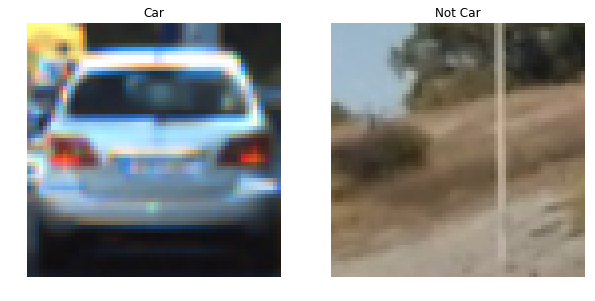

In [4]:
# Randomly select the images of car and nonecar
car_ind = np.random.randint(0, n_cars)
notcar_ind = np.random.randint(0, n_notcars)

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

images = []
images.append(car_image)
images.append(notcar_image)

plt.figure(figsize=(10, 20))
plt.subplot(len(images), 2, 1)
plt.imshow(car_image)
plt.axis('off')
plt.title('Car')
 
plt.subplot(len(images), 2, 2)
plt.imshow(notcar_image) 
plt.axis('off')
plt.title('Not Car')

### Selection of color space and setting of fog feature quantity

The set value of the hog feature is as follows.
* orientations: Number of bins in histogram (9)
* pixels_per_cell: Cell size (8, 8)
* cells_per_block: Number of cells per block (2, 2)

As shown in the figure below, similar to cars and cars, the gradient direction of the cell brightness can be sufficiently discerned by visual observation and the actual test results also gave good results

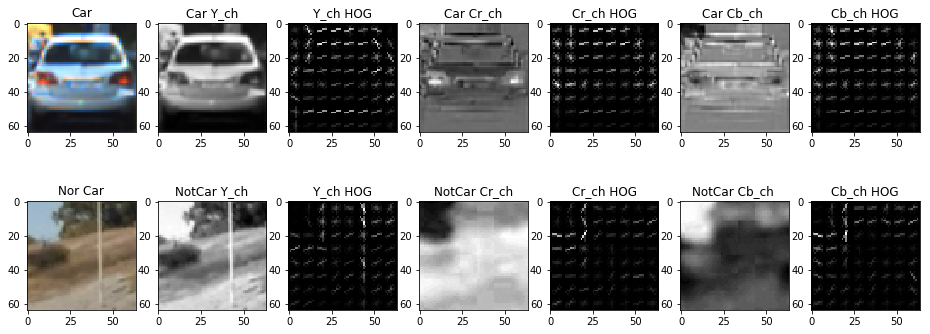

In [5]:
# Define function to explore the colourspace and HOG features
def ret_hog_feature(image, color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2):
    
    imgs = []
    imgs.append(image)
    
    feature_image = convert_color(image, conv=color_space)
    
    for i in range(feature_image.shape[2]):
        imgs.append(feature_image[:,:,i])
        hog_feature, hog_img = get_hog_features(feature_image[:,:,i], orient, pix_per_cell, cell_per_block,
                         vis=True, feature_vec=False)
        
#        print(hog_img.shape)
        imgs.append(hog_img)
    
    return imgs       

# As a result of trying by changing the color space to be applied, good results were obtained with YCrCb.
images = ret_hog_feature(car_image, color_space='YCrCb', orient=9, pix_per_cell=8)
images.extend(ret_hog_feature(notcar_image, color_space='YCrCb', orient=9, pix_per_cell=8))

titles = ['Car','Car Y_ch', 'Y_ch HOG', 'Car Cr_ch', 'Cr_ch HOG', 'Car Cb_ch ', 'Cb_ch HOG',
          'Nor Car','NotCar Y_ch', 'Y_ch HOG', 'NotCar Cr_ch', 'Cr_ch HOG', 'NotCar Cb_ch ', 'Cb_ch HOG']

fig = plt.figure(figsize=(16, 6))
for i, img in enumerate(images):
    plt.subplot(2, 7, i+1)
    plt.title(i+1)
    plt.imshow(img, cmap='gray')
    plt.title(titles[i])

In [6]:
# Define a function to extract features from a single image
def single_img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel, spatial_size):

    # Define an empty list to receive features
    img_features = []
    
    # Compute spatial features if flag is set    
    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #Append features to list
        img_features.append(spatial_features)

    # Compute histogram features if flag is set           
    if hist_feat:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append features to list
        img_features.append(hist_features)
            
    # Compute HOG features if flag is set               
    if hog_feat:
        if hog_channel == "ALL":
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                orient, pix_per_cell, cell_per_block,
                                                vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                                orient, pix_per_cell, cell_per_block,
                                                vis=False, feature_vec=True)
        # Append features to lis
        img_features.append(hog_features)     
        
    return img_features

In [7]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        
        file_features = []

        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, conv=color_space)
         
        #Get the features
        file_features = single_img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel, spatial_size)
        
        #Append features to the list 
        features.append(np.concatenate(file_features))
       
    return features 

### Extraction of features and creation and storage of models

In [8]:
# Define feature parameters
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()
car_feature = extract_features(cars,color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                              cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_feature = extract_features(notcars,color_space=color_space,spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                              cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(t2-t,  'Seconds to extract features...')

# Create an array stack of feature vectors
X = np.vstack((car_feature, notcar_feature)).astype(np.float64)

# Normlise the features
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_feature)), np.zeros(len(notcar_feature))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state = rand_state)

print("Training and test data are ready")
print("Feature vector length:", len(X_train[0]))

68.7328634262085 Seconds to extract features...
Training and test data are ready
Feature vector length: 8460


### Training SVM Model

In [9]:
# Check the training time for the SVC
t = time.time()
# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'seconds to train linear model')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

16.59000587463379 seconds to train linear model
Test Accuracy of SVC =  0.9918


### Save and load features and model

In [10]:
features_pickle = {}
features_pickle["svc"] = svc
features_pickle["X_scaler"] = X_scaler
pickle.dump(features_pickle, open("./features_pickle.p", "wb"))

print("Features and SVC Model Saved ...")

Features and SVC Model Saved ...


In [11]:
#Load saved features and model
features_pickle = pickle.load(open("./features_pickle.p", "rb"))
svc = features_pickle["svc"]
X_scaler = features_pickle["X_scaler"]

### Main function definition of vehicle detection(for single image)

In [12]:
#Define feature parameters
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

In [13]:
# Define a function that extract features and predict using hog subsampling
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_sapce, vis=False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    heatmap = np.zeros_like(img[:,:,0])
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_sapce)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
#                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                                
                bbox = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))

                if vis:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(bbox)
                
    return bboxes, draw_img

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, thick=6):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), thick)
    # Return the image
    return img

### Visualization of heat map and integration results

This section shows the results of BBox's decision. Search the trained SVC and specified window range and detect the vehicle. The detected result is calculated as a feed map. The calculated feed map can be paraphrased as being indicative of the strength of the car likeness. Therefore we exclude weak heat map by threshold. In addition, the results are merged and labeled as one result, and detection results are shown as individual vehicles.

In [14]:
# Define a function that extract features and predict using hog subsampling(For multi window examination)
def slide_win_test(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_sapce, vis=False):
    
    draw_img = np.copy(img)  
    img_tosearch = img[ystart:ystop,:,:]
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))    

    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell)-1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell)-1   
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
                                
            bbox = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
            if vis:
                if((ytop_draw+win_draw+ystart) <= ystop):
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
            bboxes.append(bbox)
    return bboxes, draw_img

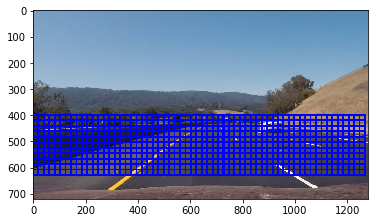

In [15]:
image = cv2.imread('./test_images/dist1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ystart = 400
ystop = 670
scale = 1.3 #0.8-2.2

found_boxes, draw_img = slide_win_test(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, vis = True)
      
plt.imshow(draw_img)

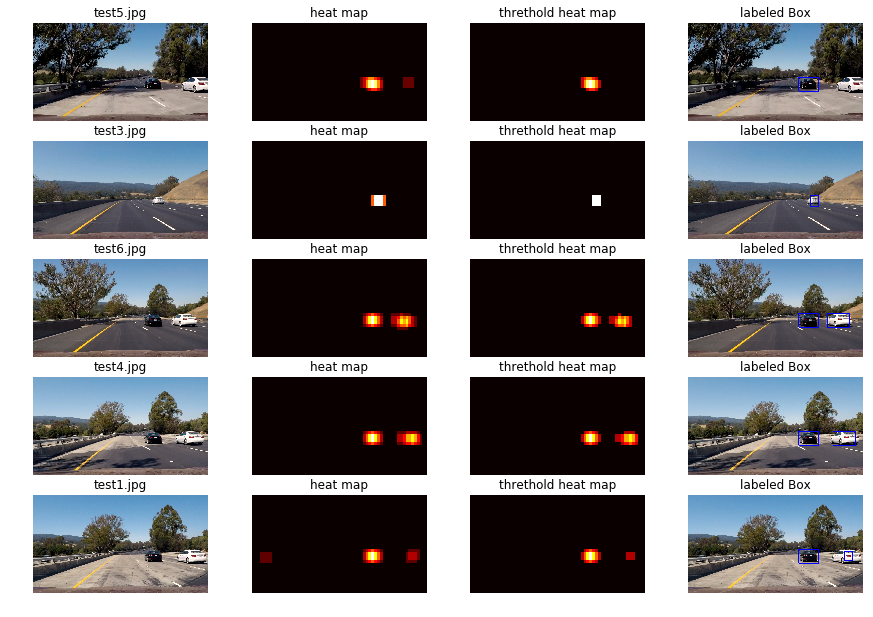

In [16]:
# Vizualize results of test_images
test_images = glob.glob('test_images/test*')
out_images = []
out_titles = []
detected_cnt = 0

ystart = 400
ystop = 670
scale = 1.3 #0.8-2.2

plt.figure(figsize=(15, 30))
#print(len(images))
for i, image in enumerate(test_images):
    img = mpimg.imread(image)

    org_img = np.copy(img)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    found_boxes, draw_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, vis = True)

    if len(found_boxes) != 0:
        heatmap1 = add_heat(heat, found_boxes)
        heatmap2 = np.copy(heatmap1)
        heatmap2 = apply_threshold(heatmap2,1)
        labels = label(heatmap2)
        finalized = draw_labeled_bboxes(img, labels)        
        
        plt.subplot(len(images), 4, i*4 + 1)
        plt.imshow(org_img)
        plt.axis('off')
        plt.title(os.path.basename(image))
 
        plt.subplot(len(images), 4, i*4 + 2)
        plt.imshow(heatmap1, cmap='hot') 
        plt.axis('off')
        plt.title('heat map')
    
        plt.subplot(len(images), 4, i*4 + 3)
        plt.imshow(heatmap2, cmap='hot') 
        plt.axis('off')    
        plt.title("threthold heat map")

        plt.subplot(len(images), 4, i*4 + 4)
        plt.imshow(finalized) 
        plt.axis('off')    
        plt.title("labeled Box")        
        
        detected_cnt+=1

### Define multi-window setting suitable for vehicle position(size)

This section describes the process of setting the appropriate search window according to the position of the vehicle. Window range specification and scaled multi window are defined as follows. The image used is different in the position of the vehicle. Good results were obtained with the setting as below.

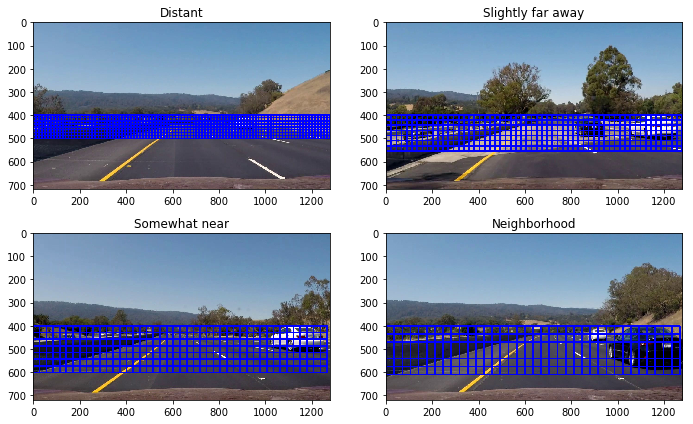

In [17]:
img_list =['./test_images/dist1.jpg','./test_images/dist2.jpg','./test_images/dist3.jpg','./test_images/dist4.jpg']
titles   =['Distant', 'Slightly far away','Somewhat near','Neighborhood']
multi_wins = [(400, 520, 0.8), (400, 600, 1.4), (400, 650, 1.8), (400, 670, 2.2)] #trial

#print(multi_wins[0][1])

fig = plt.figure(figsize=(10, 6))
for i, img in enumerate(img_list):
    img = mpimg.imread(img)

    ystart = multi_wins[i][0]
    ystop  = multi_wins[i][1]
    scale  = multi_wins[i][2]   
    
    found_boxes, draw_img = slide_win_test(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, vis = True)     
    plt.subplot(2, 2, i+1)
    plt.tight_layout()
    plt.title(i+1)
    plt.imshow(draw_img, cmap='gray')
    plt.title(titles[i])


### Results of applying the above examination results to pipeline.

In [18]:
global heat_collect

def pipeline(image):
    #variables
    color_space = 'YCrCb'
    orient = 9  
    pix_per_cell = 8 
    cell_per_block = 2 
    hog_channel = 'ALL'
    spatial_size = (32, 32) 
    hist_bins = 32 
    spatial_feat = True 
    hist_feat = True 
    hog_feat = True 

    # define multi windows size for searching
    multi_wins = [(380, 500, 0.8), (380, 670, 1.4), (400, 670, 1.8), (400, 670, 2.2)] #OK
    # multi_wins = [(400, 520, 0.8), (400, 600, 1.4), (400, 650, 1.8), (400, 670, 2.2)] #trial

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
   
    #img copy
    draw_img = np.copy(image)
    
    car_detections = []
    for win in multi_wins:
        ystart = win[0]
        ystop  = win[1]
        scale  = win[2]

        found_boxes, _ = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)

        if len(found_boxes) != 0:
            car_detections.extend(found_boxes)
            
    if len(car_detections) != 0:
        heatmap = add_heat(heat, car_detections)
        heat_collect.append(heatmap)
        heatmap = np.average(heat_collect, axis=0) # smoothing
        heatmap = apply_threshold(heatmap, 2)
        clilped_heatmap = np.clip(heatmap, 0, 255)
        labels = label(clilped_heatmap)
        draw_bboxes = draw_labeled_bboxes(draw_img, labels)
        return draw_bboxes
    
    return image

#### Processing of project video

In [19]:
heat_collect = deque(maxlen=15)

output = 'output_test_video.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_test_video.mp4
[MoviePy] Writing video output_test_video.mp4


 97%|█████████▋| 38/39 [00:42<00:01,  1.12s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test_video.mp4 

CPU times: user 57.9 s, sys: 280 ms, total: 58.2 s
Wall time: 43 s


#### Processing of project video

In [20]:
heat_collect = deque(maxlen=15)

output = 'output_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [23:00<00:01,  1.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 32min 33s, sys: 10.1 s, total: 32min 44s
Wall time: 23min


#### Processing of advanced lane finding result video

In [21]:
heat_collect = deque(maxlen=15)

output = 'output_ld_project_video.mp4'
clip1 = VideoFileClip("ld_project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_ld_project_video.mp4
[MoviePy] Writing video output_ld_project_video.mp4


100%|█████████▉| 1260/1261 [22:49<00:01,  1.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_ld_project_video.mp4 

CPU times: user 32min 25s, sys: 9.78 s, total: 32min 35s
Wall time: 22min 49s


### Discussion

The effectiveness of vehicle detection using HOG and SVM included in conventional machine learning was shown this project. However, the following problems can be mentioned.

* BBox is displayed besides the vehicle. False detection occurs.
* Detection processing time is long. In a general-purpose LSI for automotive use, real-time processing is difficult.
* The fitness degree of the BBox and the vehicle may be low. When the distance meter is used only with the monocular camera, the higher the fit degree, the more accurate distance calculation becomes possible.
* In some cases, it can not be detected normally due to occlusion.

To improve detection accuracy, vehicle detection using R - CNN on the GPU is effective. For example, Yolo, SSD, Multi-net, etc. This is considered to make it possible to detect robust against occlusion, directional differences, etc.
When using conventional machine learning, I think that images with different sizes can be detected in a short time by using pyramid images in addition to the search range applied this project.

